In [0]:
import cv2
import numpy as np
import tensorflow as tf

from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [0]:
images, labels = [], []

data_paths = ['mask', 'no_mask']
for paths in data_paths:
  path = glob(paths + '/*.jpg')

  for image in path:
    img_array = cv2.imread(image)
    img_array = cv2.resize(img_array, (224, 224))
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    if paths == 'mask':
      labels.append(1)
    else:
      labels.append(0)

    images.append(img_array)

In [0]:
images = np.array(images, dtype='float32')
labels = np.array(labels)

In [0]:
images.shape

(2943, 224, 224, 3)

In [0]:
labels = tf.keras.utils.to_categorical(labels)
labels.shape

(2943, 2)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)
X_train.shape, X_test.shape

((2354, 224, 224, 3), (589, 224, 224, 3))

In [0]:
augmentor = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                            zoom_range=0.20,
                                                            width_shift_range=0.20,
                                                            height_shift_range=0.20,
                                                            shear_range=0.15,
                                                            horizontal_flip=True,
                                                            fill_mode='nearest')

In [0]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
head = base_model.output
head = tf.keras.layers.AveragePooling2D(pool_size=(7, 7)) (head)
head = tf.keras.layers.Flatten() (head)
head = tf.keras.layers.Dense(128, activation='relu') (head)
head = tf.keras.layers.Dropout(0.5) (head)
head = tf.keras.layers.Dense(2, activation='softmax') (head)

model = tf.keras.models.Model(inputs=base_model.input, outputs=head)

for layer in base_model.layers:
  layer.trainable = False

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
LR = 1e-4
BATCH_SIZE = 128
EPOCHS = 20

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=LR, decay=LR/EPOCHS)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [0]:
history = model.fit(augmentor.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) // BATCH_SIZE,
                    epochs=EPOCHS)

Epoch 1/20
18/18 [==============================] - 29s 2s/step - loss: 0.7281 - accuracy: 0.6433 - val_loss: 0.3593 - val_accuracy: 0.8659
Epoch 2/20
18/18 [==============================] - 26s 1s/step - loss: 0.4411 - accuracy: 0.7951 - val_loss: 0.2489 - val_accuracy: 0.9287
Epoch 3/20
18/18 [==============================] - 26s 1s/step - loss: 0.3321 - accuracy: 0.8558 - val_loss: 0.2084 - val_accuracy: 0.9321
Epoch 4/20
18/18 [==============================] - 26s 1s/step - loss: 0.2891 - accuracy: 0.8814 - val_loss: 0.1867 - val_accuracy: 0.9406
Epoch 5/20
18/18 [==============================] - 26s 1s/step - loss: 0.2452 - accuracy: 0.8998 - val_loss: 0.1774 - val_accuracy: 0.9338
Epoch 6/20
18/18 [==============================] - 26s 1s/step - loss: 0.2333 - accuracy: 0.9070 - val_loss: 0.1725 - val_accuracy: 0.9372
Epoch 7/20
18/18 [==============================] - 26s 1s/step - loss: 0.2230 - accuracy: 0.9079 - val_loss: 0.1628 - val_accuracy: 0.9372
Epoch 8/20
18/18 [==

In [0]:
preds = model.predict(X_test)
pred_idx = np.argmax(preds, axis=1)

print(classification_report(y_test.argmax(axis=1), pred_idx))

              precision    recall  f1-score   support

           0       0.97      0.90      0.94       313
           1       0.90      0.97      0.93       276

    accuracy                           0.93       589
   macro avg       0.93      0.94      0.93       589
weighted avg       0.94      0.93      0.93       589



In [0]:
model.save('mask_model.h5')

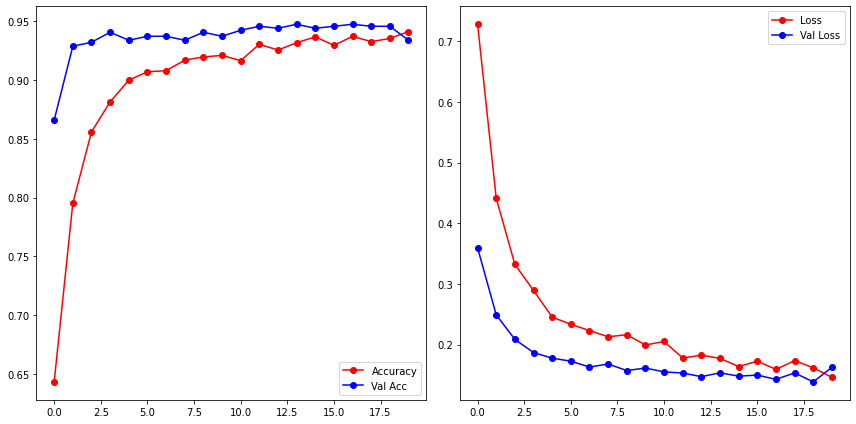

In [0]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'r-o', label='Accuracy')
plt.plot(history.history['val_accuracy'], 'b-o', label='Val Acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'r-o', label='Loss')
plt.plot(history.history['val_loss'], 'b-o', label='Val Loss')
plt.legend()

plt.tight_layout()

In [0]:
from google.colab import files
files.download('mask_model.h5')

In [0]:
import face_recognition

In [0]:
def pred_mask(img, model):
  pred = model.predict(img.reshape(1, 224, 224, 3))
  mask = np.argmax(pred)

  if mask == 1:
    return 'Mask'
  else:
    return 'No Mask'

In [0]:
def detect_mask(image, model=model):
  original_image = cv2.imread(image)
  resized_img = cv2.resize(original_image, (224, 224))

  faces = face_recognition.face_locations(original_image)
  for face in faces:
    top, right, bottom, left = face
    face_roi = original_image[top:bottom, left:right]
    resized_img = cv2.resize(face_roi, (224, 224))

    input_img = tf.keras.applications.mobilenet_v2.preprocess_input(resized_img)

    mask = pred_mask(input_img, model)
    print('Mask: ', mask)

    original_image = cv2.rectangle(original_image, (top, left), (bottom, right), (36,255,12), 1)
    cv2.putText(original_image, mask, (top, left-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

  return original_image

In [0]:
img = glob('no_mask/*.jpg')[10]

In [0]:
result = detect_mask(img)

Mask:  No Mask


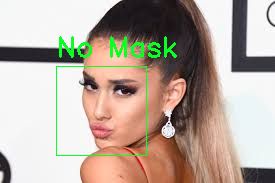

In [0]:
cv2_imshow(result)